In [1]:
import numpy as np
from glob import glob
#from bing_image_downloader import downloader
import json
from tqdm import tqdm
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot as plt
from tensorflow.keras.applications import resnet
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os


CROP = 256
target_shape = (CROP,CROP)
input_img_size = (CROP, CROP, 3)

2023-02-21 21:14:34.925653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 21:14:35.447631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-21 21:14:35.447675: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64

In [2]:
#artist = [i.split('/')[-1] for i in glob('./album/*')]

def open_frame(var=1,CROP = 256):
    

    op = glob(f'./datasets/children/*')
    
    while True:
        input_path = np.random.choice(op)
        
        if os.path.exists(input_path):
            break


    img = np.asarray(cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB), dtype=np.float32)
    img = cv2.resize(img,(CROP,CROP))
    img = img - np.amin(img)
    input_channel = img/np.amax(img)
    input_channel += -1

    '''
    while True:
        
        c = np.random.choice(202599)
        if len(str(c)) < 6:
            c = np.asarray(np.asarray(np.zeros(6-len(str(c))),dtype='int'),dtype='str')[0]+str(c)
    
        celebrity = f'./datasets/celebrities/img_align_celeba/{c}.jpg'
        
        if os.path.exists(celebrity):
            break
    '''
    
    
    op = glob(f'./datasets/humans/*')
    
    while True:
        celebrity = np.random.choice(op)
        
        if os.path.exists(celebrity):
            break

    cover = np.asarray(cv2.cvtColor(cv2.imread(celebrity), cv2.COLOR_BGR2RGB), dtype=np.float32)
    cover = cv2.resize(cover,(CROP,CROP))
    cover = cover - np.amin(cover)
    cover_channel = cover/np.amax(cover)
    cover_channel += -1
    
    
    return np.array([input_channel, cover_channel])


In [3]:
def augment(yx, crop=256, do_flips=False, do_rotate=True, do_scale=False):
    
    if do_flips:
        if np.random.uniform(0,1) > 0.5:
            if np.random.uniform(0,1) > 0.5:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],0)
            else:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],1)
 
    if do_rotate:
        ch, cw = yx[0].shape[:2]
        
        for i in range(len(yx)):

            rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),np.random.randint(-20,20),1)
            yx[i] = cv2.warpAffine(yx[i],rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    
    return yx

In [4]:
N_REPEAT_FRAME = 2

def sample_images():
    while True:
        try:
            img = open_frame()
        except Exception as e:
            print(f'Exception {e} on file')
            continue
            #break
        for n in range(N_REPEAT_FRAME):
            #img = open_frame(np.random.choice(band))
            a =  augment(img,crop = CROP)
            yield a

In [5]:
def get_data_generator(sampler):
    def get_data():
        while True:
            yx = next(sampler)
            
            x, y = yx[0], yx[1]
            
            #yield x,y
            yield {"generator_G_img_input":x,"generator_F_img_input":y}
    return get_data

In [6]:
BATCH_SIZE = 10

dg_train = tf.data.Dataset.from_generator(
    get_data_generator(sample_images()),
    output_types=({"generator_G_img_input":tf.float32,"generator_F_img_input":tf.float32}),
    output_shapes=({"generator_G_img_input":(CROP, CROP, 3),"generator_F_img_input":(CROP, CROP, 3)}) )

dg_val = tf.data.Dataset.from_generator(
    get_data_generator(sample_images()),
    output_types=({"generator_G_img_input":tf.float32,"generator_F_img_input":tf.float32}),
    output_shapes=({"generator_G_img_input":(CROP, CROP, 3),"generator_F_img_input":(CROP, CROP, 3)}) )

gen_batch_train = dg_train.batch(BATCH_SIZE)
gen_batch_val = dg_val.batch(BATCH_SIZE)

2023-02-21 21:14:36.590192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 21:14:36.590385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 21:14:36.616699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 21:14:36.616923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 21:14:36.617090: I tensorflow/compiler/xla/stream_executo

In [7]:
xs = next(gen_batch_train.as_numpy_iterator())

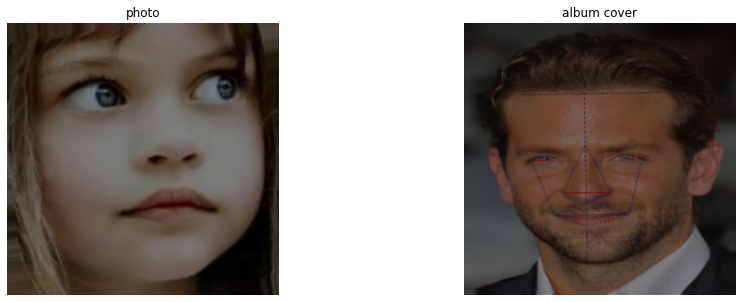

In [8]:
_ = np.random.choice(len(xs['generator_G_img_input']))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow((xs['generator_G_img_input'][_]+1)/2)
plt.axis('off')
plt.title('photo')
plt.subplot(122)
plt.imshow((xs['generator_F_img_input'][_]+1)/2)
plt.title('album cover')
plt.axis('off')

plt.show()

In [9]:
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [10]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


In [11]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")


/home/joel/anaconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [12]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        gen_val,
        lambda_cycle=10.0,
        lambda_identity=0.5,
        
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        self.gen_val = gen_val

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        x = batch_data
        real_x,real_y = x['generator_G_img_input'],x['generator_F_img_input']
        #real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F
            
            #total_loss_G = gen_G_loss + cycle_loss_G
            #total_loss_F = gen_F_loss + cycle_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }
    
    def generate_images(self):
        xs = next(self.gen_val.as_numpy_iterator())
        test_photos,test_covers = xs['generator_G_img_input'],xs['generator_F_img_input']
        
        p = self.gen_G(test_photos)
        
        return [test_photos,p]
    
    def plot_images(
        self,epoch, logs=None, figsize=(12, 5),num_images = 5
    ):
        #self.save_weights('./checkpoints/cycle_gan')
        img,p = self.generate_images()
        
        _, ax = plt.subplots(2, 5, figsize=figsize)
        
        for i in range(num_images):
            ax[0,i].imshow((p[i]+1)/2)
            ax[0,i].axis("off")
            ax[1,i].imshow((img[i]+1)/2)
            ax[1,i].axis("off")


        plt.tight_layout()
        plt.show()


Epoch 1/36


2023-02-21 21:15:38.487154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8302
2023-02-21 21:15:40.586324: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.67GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-21 21:15:40.586349: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.67GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-21 21:15:40.669626: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.67GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

  96/1000 [=>............................] - ETA: 21:37 - G_loss: 4.3427 - F_loss: 3.2892 - D_X_loss: 0.2289 - D_Y_loss: 0.1871

2023-02-21 21:18:02.561254: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 181.06MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 100/1000 [==>...........................] - ETA: 21:32 - G_loss: 4.2813 - F_loss: 3.2426 - D_X_loss: 0.2295 - D_Y_loss: 0.1824

2023-02-21 21:18:08.356826: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 181.06MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 103/1000 [==>...........................] - ETA: 21:28 - G_loss: 4.2308 - F_loss: 3.1993 - D_X_loss: 0.2290 - D_Y_loss: 0.1819

2023-02-21 21:18:12.704339: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 181.06MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 129/1000 [==>...........................] - ETA: 20:53 - G_loss: 3.8800 - F_loss: 2.9150 - D_X_loss: 0.2282 - D_Y_loss: 0.1831

2023-02-21 21:18:50.374579: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 181.06MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-21 21:18:50.374745: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 181.06MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 143/1000 [===>..........................] - ETA: 20:34 - G_loss: 3.7327 - F_loss: 2.8101 - D_X_loss: 0.2259 - D_Y_loss: 0.1885

2023-02-21 21:19:10.676624: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 181.06MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1000/1000 [==============================] - ETA: 0s - G_loss: 2.1166 - F_loss: 1.7737 - D_X_loss: 0.2138 - D_Y_loss: 0.1968

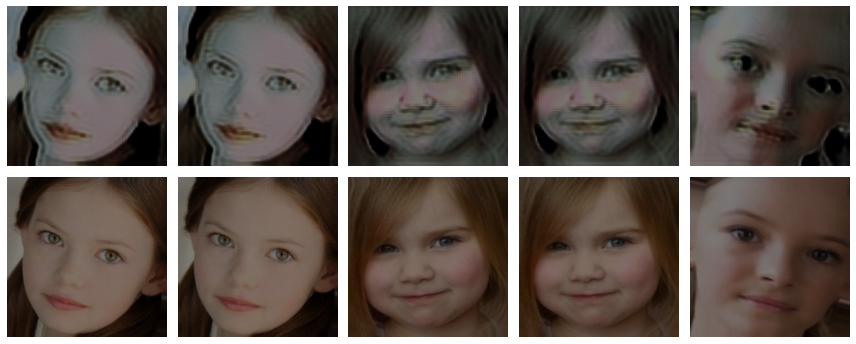

1000/1000 [==============================] - 1495s 1s/step - G_loss: 2.1162 - F_loss: 1.7735 - D_X_loss: 0.2138 - D_Y_loss: 0.1967
Epoch 2/36
1000/1000 [==============================] - ETA: 0s - G_loss: 1.7792 - F_loss: 1.4765 - D_X_loss: 0.2250 - D_Y_loss: 0.1974

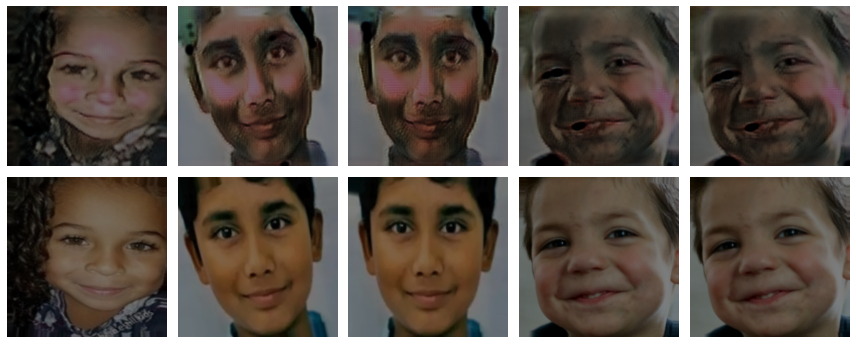

1000/1000 [==============================] - 1453s 1s/step - G_loss: 1.7795 - F_loss: 1.4765 - D_X_loss: 0.2250 - D_Y_loss: 0.1975
Epoch 3/36
1000/1000 [==============================] - ETA: 0s - G_loss: 1.7221 - F_loss: 1.3715 - D_X_loss: 0.2324 - D_Y_loss: 0.2083

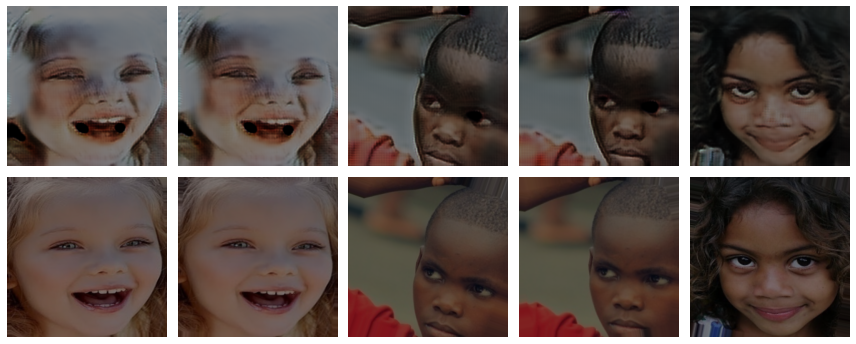

1000/1000 [==============================] - 1452s 1s/step - G_loss: 1.7219 - F_loss: 1.3713 - D_X_loss: 0.2324 - D_Y_loss: 0.2083
Epoch 4/36
1000/1000 [==============================] - ETA: 0s - G_loss: 1.6532 - F_loss: 1.3198 - D_X_loss: 0.2271 - D_Y_loss: 0.2052

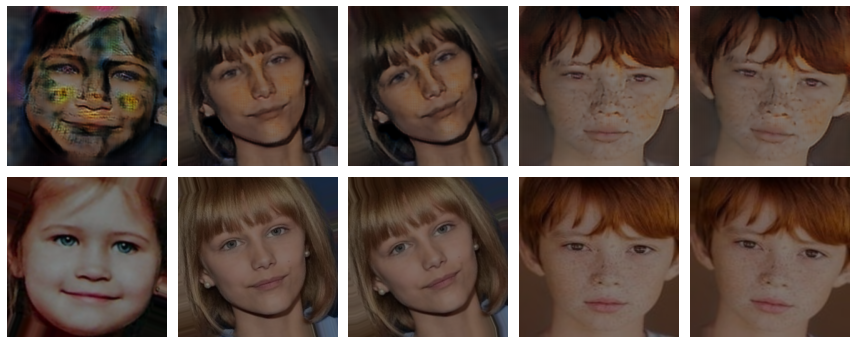

1000/1000 [==============================] - 1452s 1s/step - G_loss: 1.6530 - F_loss: 1.3199 - D_X_loss: 0.2271 - D_Y_loss: 0.2052
Epoch 5/36
1000/1000 [==============================] - ETA: 0s - G_loss: 1.6645 - F_loss: 1.2853 - D_X_loss: 0.2222 - D_Y_loss: 0.2019

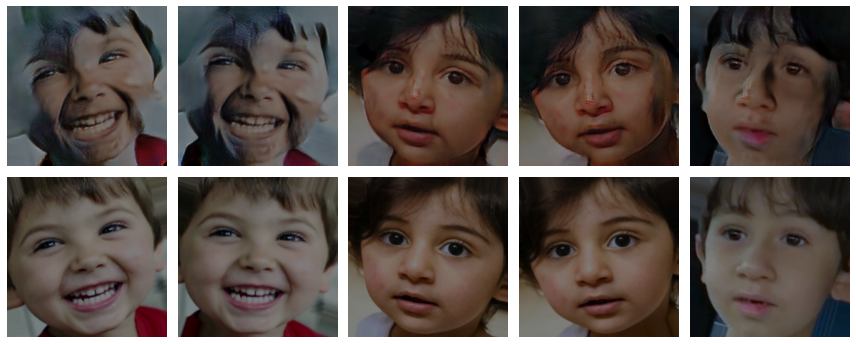

1000/1000 [==============================] - 1452s 1s/step - G_loss: 1.6643 - F_loss: 1.2853 - D_X_loss: 0.2222 - D_Y_loss: 0.2019
Epoch 6/36
1000/1000 [==============================] - ETA: 0s - G_loss: 1.6066 - F_loss: 1.2644 - D_X_loss: 0.2206 - D_Y_loss: 0.2024

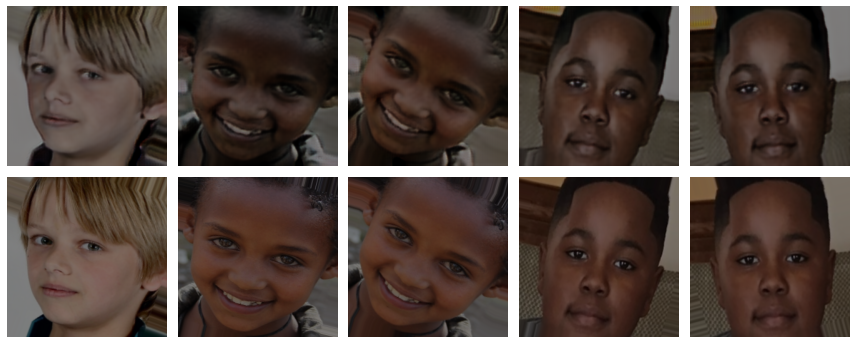

1000/1000 [==============================] - 1451s 1s/step - G_loss: 1.6070 - F_loss: 1.2643 - D_X_loss: 0.2206 - D_Y_loss: 0.2024
Epoch 7/36
1000/1000 [==============================] - ETA: 0s - G_loss: 1.5952 - F_loss: 1.2251 - D_X_loss: 0.2195 - D_Y_loss: 0.1973

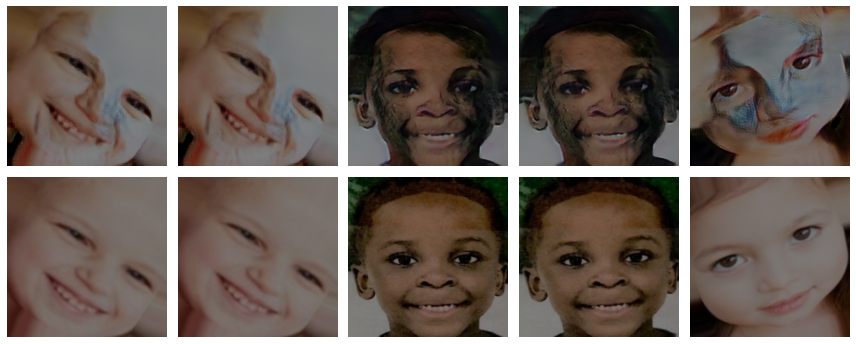

1000/1000 [==============================] - 1452s 1s/step - G_loss: 1.5949 - F_loss: 1.2251 - D_X_loss: 0.2196 - D_Y_loss: 0.1972
Epoch 8/36
 819/1000 [=======================>......] - ETA: 4:21 - G_loss: 1.5848 - F_loss: 1.1991 - D_X_loss: 0.2197 - D_Y_loss: 0.1943

2023-02-22 00:25:03.478206: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 160.00MiB (rounded to 167772160)requested by op gradient_tape/generator_G/instance_normalization_22/moments_2/BroadcastTo_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-02-22 00:25:03.478333: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-02-22 00:25:03.478345: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 541, Chunks in use: 524. 135.2KiB allocated for chunks. 131.0KiB in use in bin. 11.5KiB client-requested in use in bin.
2023-02-22 00:25:03.478354: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 40, Chunks in use: 36. 20.5KiB allocated for chunks. 18.2KiB in use in bin. 18.0KiB client-reque

ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[10,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node AddN_320-2-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_80724]

In [13]:
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y,gen_val=gen_batch_val
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

#cycle_gan_model.load_weights('./checkpoints/cycle_gan_growing')

# Callbacks
#plotter = GANMonitor()
plotter = tf.keras.callbacks.LambdaCallback(on_epoch_end=cycle_gan_model.plot_images)
checkpoint_filepath = './checkpoints/cycle_gan_growing20'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only = True
    
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    gen_batch_train,
    epochs=36,
    steps_per_epoch=1000,
    callbacks=[plotter,model_checkpoint_callback],
)

In [ ]:
p = cycle_gan_model.gen_G(xs['generator_F_img_input'])
q = cycle_gan_model.gen_F(xs['generator_G_img_input'])

In [ ]:
_ = np.random.choice(len(p))

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow((p[_]+1)/2)
plt.axis('off')
plt.subplot(222)
plt.imshow((q[_]+1)/2)
plt.axis('off')
plt.subplot(223)
plt.imshow((xs['generator_G_img_input'][_]+1)/2)
plt.axis('off')
plt.subplot(224)
plt.imshow((xs['generator_F_img_input'][_]+1)/2)
plt.axis('off')
plt.show()

In [ ]:
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y,gen_val=gen_batch_val
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

In [ ]:
cycle_gan_model.save_weights('./checkpoints/try')

In [ ]:
cycle_gan_model.load_weights('./checkpoints/try')